# LIME-Aleph
2021-02-15

Johannes Rabold (Universität Bamberg) und Stephan Scheele (Fraunhofer IIS)

Adaptiert für den KI-Campus Kurs XAI4Ing. 


## Kontakt
Über das git Repository von LIME-Aleph oder https://www.uni-bamberg.de/en/cogsys/team/. 

## Lizenz
Diese Arbeit ist lizenziert unter [BSD-2-Clause Lizenz](https://opensource.org/licenses/BSD-2-Clause).

<hr>

Willkommen zum Beispiel für das Modul __LIME-Aleph__ im KI-Campus. Hier werden Sie den typischen Ablauf zum Finden einer symbolischen Erklärung für Black-Box Netzwerke mithilfe der LIME-Aleph Bibliothek beschreiben.

_J. Rabold, H. Deininger, M. Siebers, U. Schmid:. (2019)._ [„Enriching Visual with Verbal Explanations for Relational Concepts – Combining LIME with Aleph“](https://doi.org/10.1007/978-3-030-43823-4_16)

__Hinweis__: Bitte setzen Sie das Notebook zurück wenn sie dieses ein zweites mal ausführen möchten. 
    Im Menü über __(Kernel > Restart)__.

Zunächst importieren wir die benötigten Bibliotheken und definieren einige Parameter. 
Im Beispiel nutzen wir ein Bild zur Klassifikation und ein bereits bestehendes und vortrainiertes Modell. 

In [17]:
import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
from skimage.util import img_as_float32
from skimage.transform import resize
from scripts.train_model import own_rel
from skimage import io
from skimage.io import imshow, show, imsave
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.segmentation import mark_boundaries
import shutil
from graphviz import Digraph

import lime_aleph.lime_aleph as la

IMAGE_FILE = "pos9000.png" # The path to the image file to be classified by the black-box
MODEL = "../models_to_explain/model_tower.h5" # The path to the pre-trained model
K = 4 # Number of relevant pixels
N = 1000 # The sample size for LIME
OUTPUT_DIR = "../output/" # A path for a directory to save intermediate and output data
T = 0.8 # The threshold for the binary classifier for when an example is classified as 'positive'
NOISE = 10 # The allowed false-positive rate for Aleph in percent.b

Sollte es noch temporäre Daten aus früheren Durchläufen geben, sollen diese nun gelöscht werden:

In [18]:
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
os.makedirs(OUTPUT_DIR)

Wir laden das Bild und das vortrainierte Modell in den Speicher. 

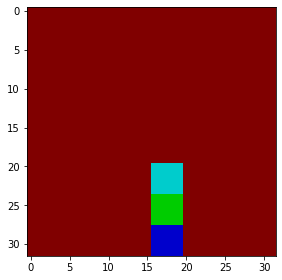

In [19]:
image = img_as_float32(io.imread(IMAGE_FILE))
image = resize(image, (own_rel.IMAGE_SIZE, own_rel.IMAGE_SIZE), anti_aliasing=True)

model = own_rel.own_rel()
model.load_weights(MODEL)

io.imshow(image)
io.show()

Wir sehen einen Turm bestehend aus drei Bauklötzen der Farben Cyan, Grün und Blau sowie den Hintergrund mit der Farbe Rot. Der blaue Bauklotz bildet das Fundament des Turms. 

## Annotation des Bildes
Im Folgenden werden die im Bild vorhandenen Elemente automatisch annotiert. 
Dazu verwenden wir die Funktion __annotate_image_parts__ aus dem Package __lime_aleph__.

In [20]:
annotated_image = la.annotate_image_parts(image, model, OUTPUT_DIR, N)

Running LIME...
True class of the image is:  1
Starting the explanation generation process. This may take a while.


/Users/sees/.virtualenvs/lime-aleph/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


  0%|          | 0/1000 [00:00<?, ?it/s]

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Intercept -0.19550178206689525
Prediction_local [0.27990811]
Right: 0.023822423
Intercept 1.195501797934348
Prediction_local [0.72009187]
Right: 0.9761776
Number of superpixels: 64
Annotating the superpixels...
Weight of sp:  44 is:  0.11377470839276924
Weight of sp:  60 is:  0.11304178615639565
Weight of sp:  52 is:  0.08795945624052952
Weight of sp:  48 is:  -0.04157252842629051
Weight of sp:  30 is:  -0.035766440198751734
Weight of sp:  9 is:  -0.03528931644250892
Weight of sp:  41 is:  -0.03263890363413267
Weight of sp:  61 is:  -0.032198573842397535
Weight of sp:  27 is:  -0.030041067752344712
Weight of sp:  32 is:  -0.02877950343512512
Weight of sp:  35 is:  -0.02861208429839908
Weight of sp:  20 is:  -0.027002034988467493
Weight of sp:  53 is:  -0.02475970316273246
Weight of sp:  28 is:  -0.024536632648778534
Weight of sp:  46 is:  -0.024522903635610972
Weight of sp:  4 is:  -0.023362396476048566
Weight of sp:  17 is:  -0.020869897452599668
Weight of sp:  25 is:  -0.020206820899

Die Funktion findet auch die Bildteile, die laut LIME für die Klasse am wichtigsten sind. Wir können diese Teile sowohl für die positive als auch für die negative Klasse visualisieren.
Das erste Bild zeigt die wichtigsten Features im Bild für die Klasse __Turm__, hier werden die drei Bauklötze erkannt.  

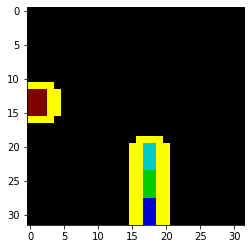

In [23]:
true_class = 1

temp, mask = annotated_image.explanation.get_image_and_mask(true_class, positive_only=True, num_features=K, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

Das zweite Bild zeigt dazu konträre Superpixel zur Klasse Turm, d.h. es werden Bereiche der Hintergrundfarbe identifiziert, die voneinander entfernt sind und nicht alle einander berühren wie die Bauklötze des Turms.

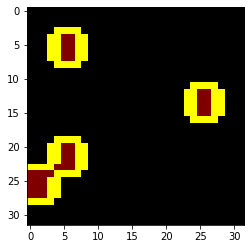

In [24]:
negative_class = 0

temp, mask = annotated_image.explanation.get_image_and_mask(negative_class, positive_only=True, num_features=K, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

Nachdem das Bild nun annotiert ist, wollen wir nun die wichtigsten __K (=4)__ Bildelemente mit der Funktion __find_important_parts__ finden. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


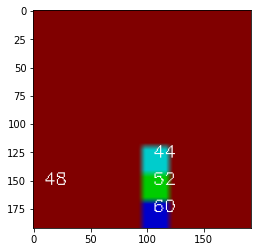

In [25]:
important_superpixels, labeled_image = la.find_important_parts(annotated_image, K)

plt.imshow(labeled_image)

In [26]:
important_superpixels

Im Bild werden den Bereichen Zahlen d.h. Klassenidentifier zugeordnet. 
Anschließend können wir die Relationen zwischen diesen Bildteilen mit der Funktion __find_spatial_relations__ identifizieren und als Graph extrahieren. 
Dies geschieht über die Funktion __find_spatial_relations__, angewendet auf die wichtigen Bildteile (Objekt __important_superpixels__). 

In [27]:
relations, graph = la.find_spatial_relations(important_superpixels)

Den Graph können wir nun mittels Graphviz visualisieren. 
Dieser beschreibt anhand binärer Relationen die topologischen Abhängigkeiten zwischen den einzelnen Objektklassen.
Die Kanten und deren Label repräsentieren die räumlichen Relationen. 

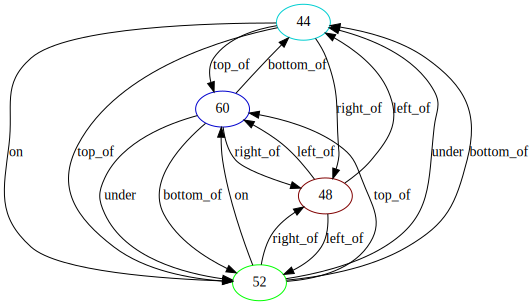

In [28]:
graph

Diese Relationen können wir auch textuell ausgeben lassen: 

In [29]:
for rel in relations:
    print(rel)

Relation: 60--bottom_of-->44
Relation: 52--under-->44
Relation: 52--bottom_of-->44
Relation: 48--left_of-->44
Relation: 44--top_of-->60
Relation: 52--on-->60
Relation: 52--top_of-->60
Relation: 48--left_of-->60
Relation: 44--on-->52
Relation: 44--top_of-->52
Relation: 60--under-->52
Relation: 60--bottom_of-->52
Relation: 48--left_of-->52
Relation: 44--right_of-->48
Relation: 60--right_of-->48
Relation: 52--right_of-->48


## Erzeugung perturbierter Instanzen
Nun lassen wir uns das perturbierte Datenset für LIME-Aleph generieren. Hierzu nutzen wir die Funktion __perturb_instance__ mit den erforderlichen Parametern. Dabei geben wir im Anschluss auch aus, wie viele Instanzen im neuen Datenset enthalten sind (Liste der Instanzen).

In [30]:
perturbed_dataset = la.perturb_instance(annotated_image, relations, model, T)
print("Number of perturbed instances:", len(perturbed_dataset))

/Users/sees/.virtualenvs/lime-aleph/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Number of perturbed instances: 17


Diese Instanzen können wir inspizieren und sehen dabei, dass positive und negative Beispiele generiert werden.

In [31]:
for ex in perturbed_dataset:
    print(ex)
    print("-------------------------------")

Example: Positive: True,
Superpixels:
60, 44,
52,
48,

Relations:
Relation: 60--bottom_of-->44
, Relation: 52--under-->44
, Relation: 52--bottom_of-->44
, Relation: 48--left_of-->44
, Relation: 44--top_of-->60
, Relation: 52--on-->60
, Relation: 52--top_of-->60
, Relation: 48--left_of-->60
, Relation: 44--on-->52
, Relation: 44--top_of-->52
, Relation: 60--under-->52
, Relation: 60--bottom_of-->52
, Relation: 48--left_of-->52
, Relation: 44--right_of-->48
, Relation: 60--right_of-->48
, Relation: 52--right_of-->48

-------------------------------
Example: Positive: False,
Superpixels:
60, 44,
52,
48,

Relations:
Relation: 44--bottom_of-->60
, Relation: 52--under-->60
, Relation: 52--bottom_of-->60
, Relation: 48--left_of-->60
, Relation: 60--top_of-->44
, Relation: 52--on-->44
, Relation: 52--top_of-->44
, Relation: 48--left_of-->44
, Relation: 60--on-->52
, Relation: 60--top_of-->52
, Relation: 44--under-->52
, Relation: 44--bottom_of-->52
, Relation: 48--left_of-->52
, Relation: 60--

Jetzt visualisieren wir noch alle Instanzen aus dem perturbierten Datenset. Erst die positiven Instanzen für die die Klasse Turm weiterhin gilt:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


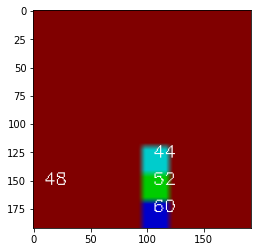

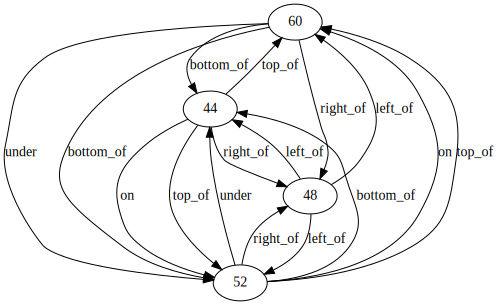

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------


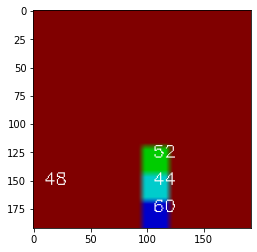

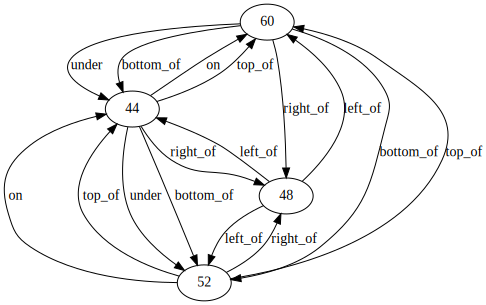

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------


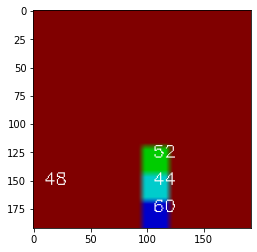

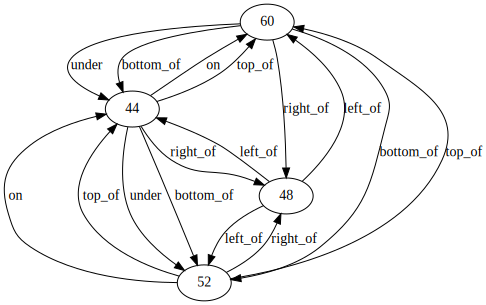

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------


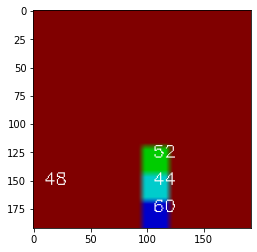

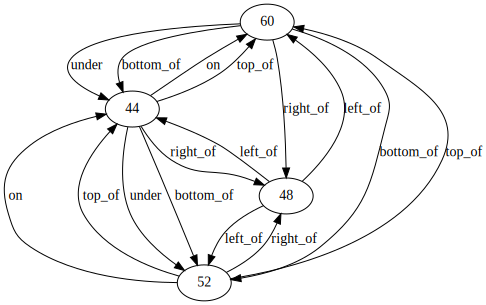

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------


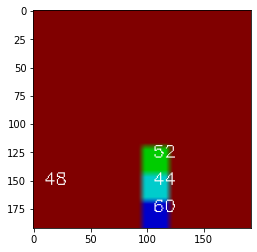

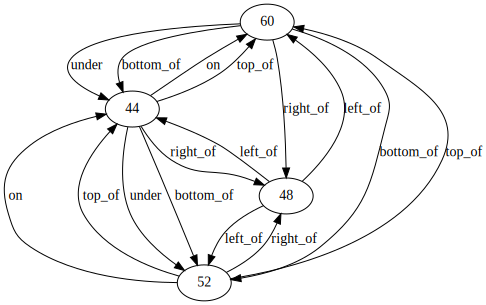

-------------------------------


In [32]:
for ex in perturbed_dataset:
    if ex.positive:
        plt.imshow(ex.labeled_image)
        plt.show()
        display(ex.graph)
        print("-------------------------------")

Und nun alle negativen Instanzen, für die die Klasse Turm nicht mehr gilt.
Dies ist per Definition der Fall wenn der __dunkelblaue Bauklotz__ __nicht__ mehr das __Fundament bildet__ d.h. ganz unten platziert ist und/oder die __Bauklötze räumlich voneinander getrennt__ sind. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


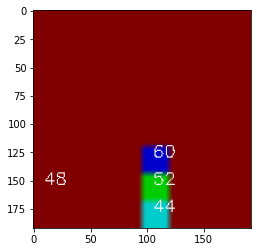

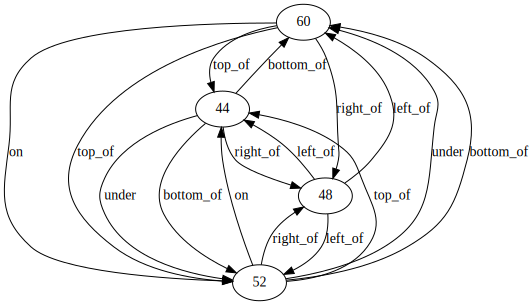

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------


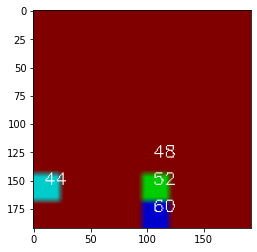

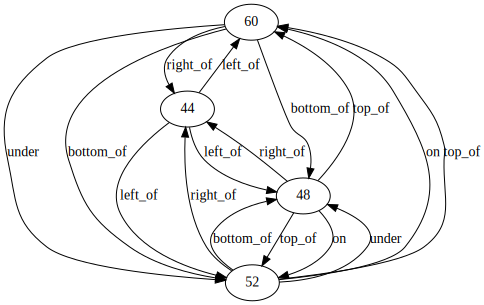

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------


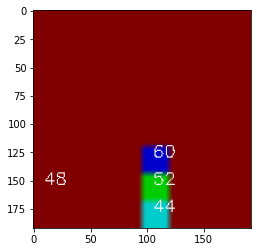

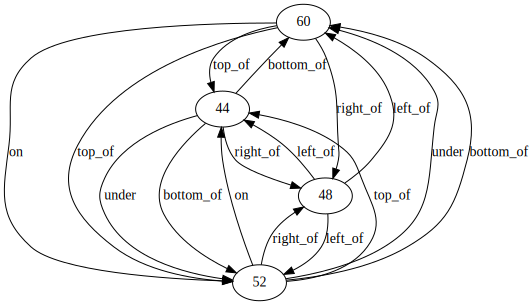

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------


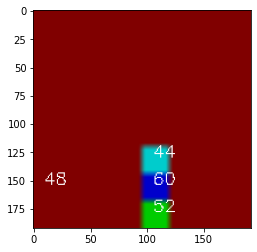

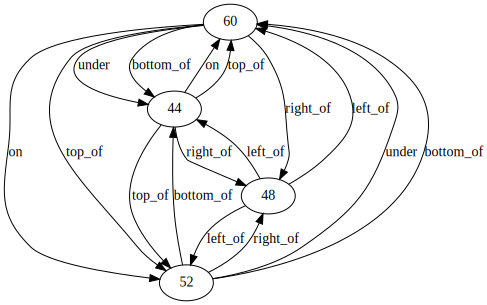

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------


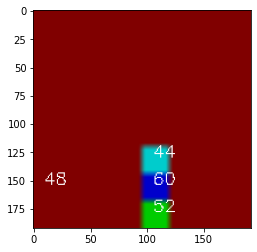

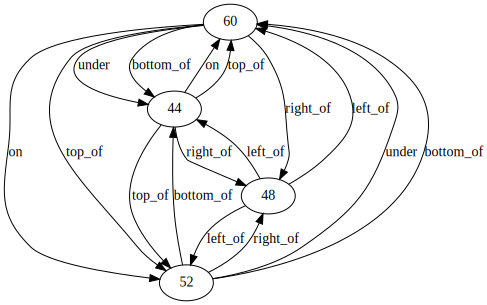

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------


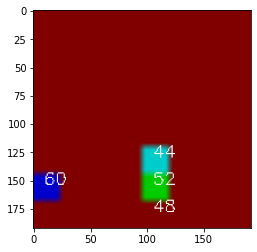

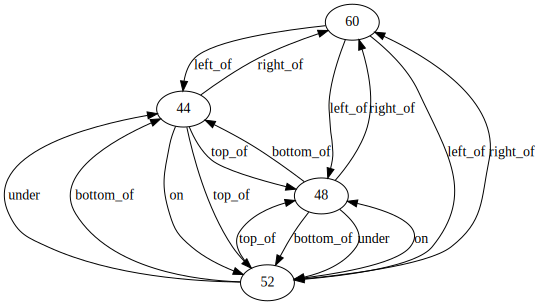

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------


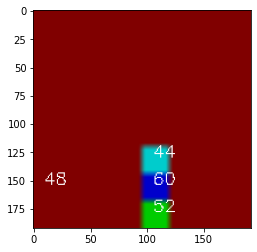

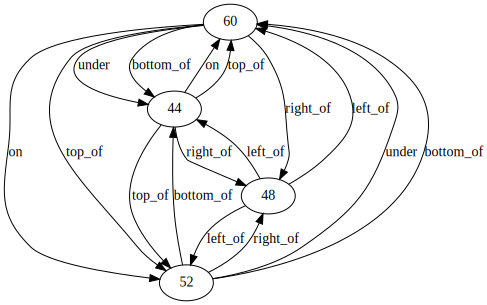

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------


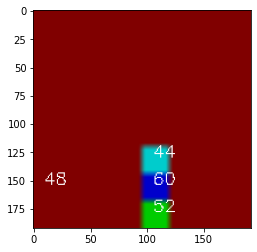

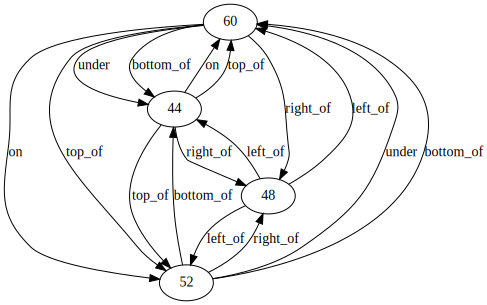

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------


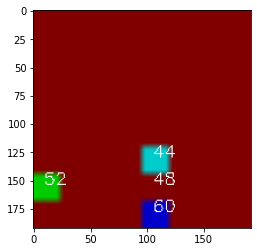

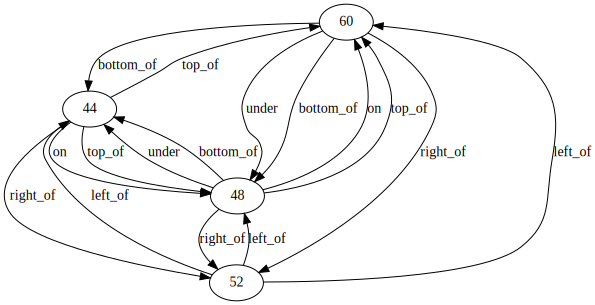

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------


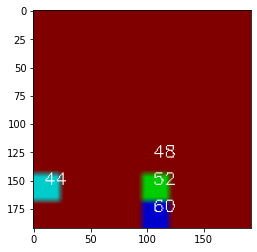

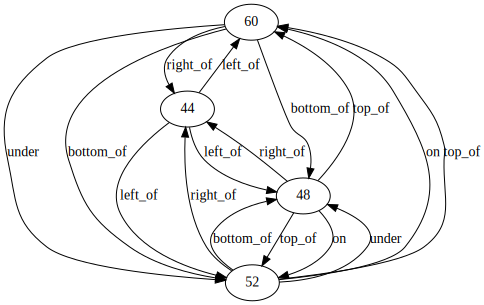

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------


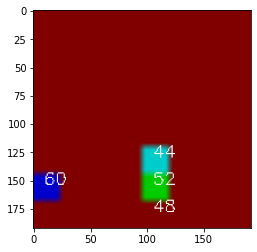

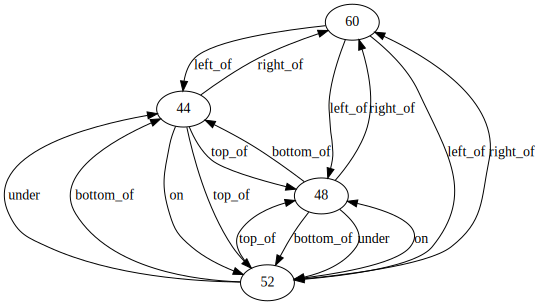

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------


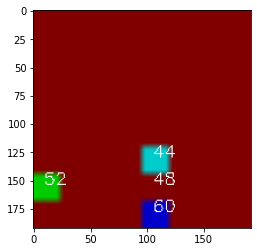

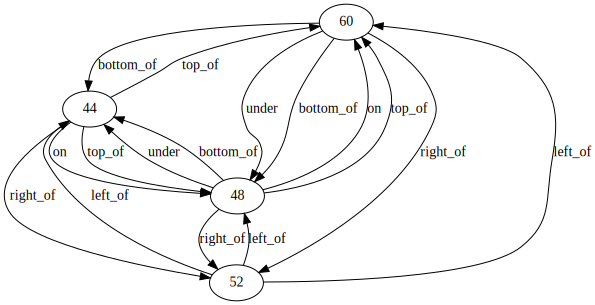

-------------------------------


In [33]:
for ex in perturbed_dataset:
    if not ex.positive:
        plt.imshow(ex.labeled_image)
        plt.show()
        display(ex.graph)
        print("-------------------------------")

Das ILP-Framework Aleph benötigt mehrere Hilfsdateien, die mit der Funktion __write_aleph_files__ erzeugt werden. 
Es sollen alle räumlichen Relationen verwendet werden! Zur Verfügung stehen folgende Relationen: *left_of*, *right_of*, *top_of*, *bottom_of*, *on*, *under*

In [34]:
used_relations = None # 'None' if you want to allow all relations, otherwise list with following possibilities: ["left_of", "right_of", "top_of", "bottom_of", "on", "under"]
la.write_aleph_files(annotated_image, perturbed_dataset, used_relations, OUTPUT_DIR, NOISE)

Writing the input files for Aleph...
../output/
Done.


Schlussendlich muss nun der Induktionsprozess von Aleph angestoßen werden. Dieser Schritt (mit der Funktion __run_aleph__) gibt auch die gefundene Erklärung zurück:

In [35]:
la.run_aleph(OUTPUT_DIR)

[{}]
[{}]
[{}]
[{}]
[{}]
The explanation was saved to '../output/explanation.txt'


Die Erklärung in Form von Regeln findet sich nun im angegebenen Ordner in der Datei *explanation.txt*. 
Wir lesen diese Datei aus und stellen die Regel in Form einer Prolog-Regel dar.

In [36]:
with open(OUTPUT_DIR + "explanation.txt", 'r') as f:
    print(f.read())

true_class(A) :-
   contains(B,A), has_color(B,mediumblue), contains(C,A), has_color(C,lime), 
   top_of_in_ex(C,B,A).



## Interpretation
Die Interpretation der Regel wollen wir im Folgenden an einem Beispiel darstellen. 

true_class(A) :-
   contains(B,A), has_color(B,mediumblue), contains(C,A), has_color(C,lime), 
   top_of_in_ex(C,B,A).

Die Lesart der Regel ist wie folgt. Das Prädikat __true_class(A)__ entspricht der Aussage _"A ist ein Turm"_ und gilt wenn folgende Aussagen logisch wahr sind:
* der Turm A enthällt einen Bauklotz B, 
* Bauklotz B hat die Farbe Blau (__mediumblue__),
* der Turm A enthält auch einen Bauklotz C,
* der Bauklotz C hat die Farbe Grün (__lime__), und 
* C befindet sich in Relation __top_of__ zu B, d.h. C steht räumlich auf B.
